https://www.kaggle.com/dansbecker/melbourne-housing-snapshot

Link to Dataset

In [50]:
# import Libraries here
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA, StandardScaler, ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.classification import RandomForestClassifier

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:

filename = 'bank/bank-full.csv'

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [3]:
# df.count() # 45211
''' 
The count row in the
summary column gives the count of non-missing values in a variable. The difference
between the total observations and this column gives you the total number of missing
values in each column. Let us go over two more stats here: the min and max rows in the
summary column. When the min and max rows have the same value for a variable, then
the cardinality of the variable is 1.
'''
df.describe().toPandas()

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975401,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044589,None,257.5278122651712,3.0980208832791813,100.12874599059818,2.3034410449312164,None,None
3,min,18,admin.,divorced,primary,no,-8019,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,102127,yes,yes,unknown,31,sep,4918,63,871,275,unknown,yes


In [4]:
# count of Target variable
df.groupBy('y').count().show()


+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



In [5]:
df.groupBy(['education', 'y']).count().show()

+---------+---+-----+
|education|  y|count|
+---------+---+-----+
|  unknown| no| 1605|
| tertiary| no|11305|
|secondary| no|20752|
|  unknown|yes|  252|
|  primary| no| 6260|
|  primary|yes|  591|
|secondary|yes| 2450|
| tertiary|yes| 1996|
+---------+---+-----+



In [6]:
df.groupBy('y').agg({'balance': 'avg', 'age': 'avg'}).show()

+---+------------------+------------------+
|  y|      avg(balance)|          avg(age)|
+---+------------------+------------------+
| no|1303.7149691899203| 40.83898602274435|
|yes|1804.2679145396105|41.670069956513515|
+---+------------------+------------------+



Question 1: Calculate the cardinality for each variable in the dataset. Can you reject any
variables based on cardinality? (Hint: Look for cardinality of 1)

In [7]:
# cardinality check
def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approxCountDistinct(c).alias(c) for c in df.columns])
    # convert to Pandas for efficient Calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True)
    final_cardinality_df.rename(columns={0: 'Cardinality'}, inplace=True)
    # select variables with Cardinality of 1
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off]
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)
cardinality_vars_selected # no Cardinality was returned

Series([], Name: index, dtype: object)

In [8]:
# to show what the DataFrame looks like
cardinality_df

,index,Cardinality
0,age,76
1,job,11
2,marital,3
3,education,4
4,default,2
5,balance,7375
6,housing,2
7,loan,2
8,contact,3
9,day,32


Question 2: Calculate the missing value percentage for each variable in the dataset. Can
you eliminate any variables based on missing values? (Hint: Just for this exercise, reject any
variable that has more than 45 percent missing values)

In [9]:
def missing_calculation(df, miss_percentage=0.45):
    # checks for both NaN and NULL values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    # convert to Pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True)
    final_missing_df.rename(columns={0: 'missing_count'}, inplace=True)
    final_missing_df['missing_percentage'] = final_missing_df['missing_count'] / length_df
    # select variables with Cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage']>=miss_percentage]
    return final_missing_df, vars_selected


missing_df, missing_vars_selected = missing_calculation(df)
missing_vars_selected # no column has missing values up to 45%

Series([], Name: index, dtype: object)

In [10]:
missing_df

,index,missing_count,missing_percentage
0,age,0,0.0
1,job,0,0.0
2,marital,0,0.0
3,education,0,0.0
4,default,0,0.0
5,balance,0,0.0
6,housing,0,0.0
7,loan,0,0.0
8,contact,0,0.0
9,day,0,0.0


Selection techniques require all our variables to be numbers. We would go through a series of Steps to achieve this.

In [11]:
# Step 1: identify variable types
def variable_type(df):
    # seperate character & numeric types
    var_list = df.dtypes
    char_vars, num_vars = [], []
    for i in var_list:
        char_vars.append(i[0]) if i[1] in ('string') else num_vars.append(i[0])
    return char_vars, num_vars

char_vars, num_vars = variable_type(df)
print('Character_Variables: {} \n \n Number_variables: {}'.format(char_vars, num_vars))


Character_Variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y'] 
 
 Number_variables: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [12]:
# Step 2: apply StringIndexer to Character Columns

def category_to_index(df, char_vars):
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+'_index', 
                    handleInvalid='keep') for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels


df, char_labels = category_to_index(df, char_vars)
char_labels

PipelineModel_4f980fdb39d4

In [13]:
df.show(2, False) # the Dataframe has both OLD & NEW inputs

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|y  |job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|58 |management|married|tertiary |no     |2143   |yes    |no  |unknown|5  |may  |261     |1       |-1   |0       |unknown |no |1.0      |0.0          |1.0            |0.0          |0.0          |0.0       |1.0          |0.0        |

In [14]:
# let's drop the OLD inputs, so we have only NUMERIC values
df = df.select([c for c in df.columns if c not in char_vars])
df.show(2, False)
# we now have only numeric values

+---+-------+---+--------+--------+-----+--------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|age|balance|day|duration|campaign|pdays|previous|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|
+---+-------+---+--------+--------+-----+--------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|58 |2143   |5  |261     |1       |-1   |0       |1.0      |0.0          |1.0            |0.0          |0.0          |0.0       |1.0          |0.0        |0.0           |0.0    |
|44 |29     |5  |151     |1       |-1   |0       |2.0      |1.0          |0.0            |0.0          |0.0          |0.0       |1.0          |0.0        |0.0           |0.0    |
+---+-------+---+--------+--------+-----+--------+---------+-------------+---------------+-------------+-

In [15]:
# to rename _INDEX columns back to their original variable name
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

df = rename_columns(df, char_vars)

In [16]:
# Step 3: Assemble features, assmeble individual columns to one column
# function for assemble vectors
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    # assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    # select all columns for processing
    selectedCols = [target_variable_name, 'features'] + features_list
    pipeline = Pipeline(stages=stages)
    # assembler model
    assembleModel = pipeline.fit(df)
    df = assembleModel.transform(df).select(selectedCols)
    return df


# exclude target variable and select all other feaature vectors
target_variable_name = 'y'
feature_list = df.columns
feature_list.remove(target_variable_name)

df = assemble_vectors(df, feature_list, target_variable_name)


In [23]:
# just to get a peak of what the DataFrame looks like
df.show(2, False)

+---+----------------------------------------------------------------------+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+
|y  |features                                                              |age|balance|day|duration|campaign|pdays|previous|job|marital|education|default|housing|loan|contact|month|poutcome|
+---+----------------------------------------------------------------------+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+
|0.0|(16,[0,1,2,3,4,5,7,9,13],[58.0,2143.0,5.0,261.0,1.0,-1.0,1.0,1.0,1.0])|58 |2143   |5  |261     |1       |-1   |0       |1.0|0.0    |1.0      |0.0    |0.0    |0.0 |1.0    |0.0  |0.0     |
|0.0|(16,[0,1,2,3,4,5,7,8,13],[44.0,29.0,5.0,151.0,1.0,-1.0,2.0,1.0,1.0])  |44 |29     |5  |151     |1       |-1   |0       |2.0|1.0    |0.0      |0.0    |0.0    |0.0 |1.0    |0.0  |0.0     |
+---+-----------------------------------

In [24]:
df.schema['features'].metadata['ml_attr']['attrs']

{'numeric': [{'idx': 0, 'name': 'age'},
  {'idx': 1, 'name': 'balance'},
  {'idx': 2, 'name': 'day'},
  {'idx': 3, 'name': 'duration'},
  {'idx': 4, 'name': 'campaign'},
  {'idx': 5, 'name': 'pdays'},
  {'idx': 6, 'name': 'previous'}],
 'nominal': [{'vals': ['blue-collar',
    'management',
    'technician',
    'admin.',
    'services',
    'retired',
    'self-employed',
    'entrepreneur',
    'unemployed',
    'housemaid',
    'student',
    'unknown',
    '__unknown'],
   'idx': 7,
   'name': 'job'},
  {'vals': ['married', 'single', 'divorced', '__unknown'],
   'idx': 8,
   'name': 'marital'},
  {'vals': ['secondary', 'tertiary', 'primary', 'unknown', '__unknown'],
   'idx': 9,
   'name': 'education'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 10, 'name': 'default'},
  {'vals': ['yes', 'no', '__unknown'], 'idx': 11, 'name': 'housing'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 12, 'name': 'loan'},
  {'vals': ['cellular', 'unknown', 'telephone', '__unknown'],
   'idx': 13,


In [33]:
# to view the META-DATA as a Dataframe
for k, v in df.schema['features'].metadata['ml_attr']['attrs'].items():
    features_df = pd.DataFrame(v)

features_df.head()

,vals,idx,name
0,"[blue-collar, management, technician, admin., ...",7,job
1,"[married, single, divorced, __unknown]",8,marital
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education
3,"[no, yes, __unknown]",10,default
4,"[yes, no, __unknown]",11,housing


In [35]:
# reducing the Dataframe dimension using Principal Component Analysis (PCA)
no_of_components = 3
pca = PCA(k=no_of_components, inputCol='features', outputCol='pcaFeatures')
model = pca.fit(df)
result = model.transform(df).select('pcaFeatures')
result.show(truncate=False)


+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.4953647735806,-257.0420740676509,1.2449712753045807] |
|[-29.29226175164622,-150.92888640669173,1.0493026899277984] |
|[-2.150889773941845,-75.98191250436618,1.076065195538016]   |
|[-1506.1823305908113,-89.21547154672724,1.2683999536975388] |
|[-1.3750908349447704,-197.98356175494834,0.9892427009814176]|
|[-231.26679712386607,-138.56034919503722,1.0576960891394662]|
|[-447.4072782675638,-216.16541383839757,1.0066666548029033] |
|[-2.7123264447441384,-379.9785828164356,0.875150469836411]  |
|[-121.11144848214039,-49.756360259707854,1.1725853591922941]|
|[-593.1146061641073,-53.89364261832045,1.1817022732261329]  |
|[-270.4212341323415,-221.4869966182793,1.0170824073203284]  |
|[-390.2608167665407,-136.27016909339142,1.0625336862698371] |
|[-6.967616100129074,-516.9674558248698,0.8003545768065

In [37]:
# this shows that only PC1 contains 99% of the information out of the 3 PC
# let's try to scale the Data and recompute the EXPLAINED VaRIANCE
model.explainedVariance


DenseVector([0.9918, 0.0071, 0.0011])

In [42]:
# assemble and scale individual columns to one column - 'features2'
def scaled_assemble_vector(df, feature_list, target_variable_name):
    stages = []
    assembler = VectorAssembler(inputCols=feature_list, outputCol='assembled_features')
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol='features2')
    stages = [assembler, scaler]
    selectedCols = [target_variable_name, 'features2'] + feature_list
    pipeline = Pipeline(stages=stages)
    scaleAssembleModel = pipeline.fit(df)
    df = scaleAssembleModel.transform(df).select(selectedCols)
    return df


feature_list = df.columns
feature_list.remove(target_variable_name)
df = scaled_assemble_vector(df, feature_list, target_variable_name)

pca = PCA(k=3, inputCol='features2', outputCol='pcaFeatures')
model = pca.fit(df)
result = model.transform(df).select('pcaFeatures')
result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-0.656780883522954,4.312194871151715,-4.393764846983172]   |
|[-0.5905533920181225,2.7430023739084834,-2.0129736282039534]|
|[-0.7923309293106096,2.4285178222008144,-1.4128758397236354]|
|[-0.7779852947452655,4.298302632063681,-5.322505502931134]  |
|[-0.5280039534403727,6.559141503668741,-1.4081500208402007] |
|[-0.7028277580738278,2.709340734232335,-3.2263556470672334] |
|[-0.8104872327792485,1.429021001342883,-1.619935441335167]  |
|[-0.9758735335487514,2.862044859013722,0.4335559756407308]  |
|[-0.7126916038564428,5.1756377163943945,-4.531453571471411] |
|[-0.5939132026125427,2.746785250427306,-2.0709944257211284] |
|[-0.48367202786592667,2.584502296303892,-0.8133472106611472]|
|[-0.5574665926507092,2.079820030405431,-1.169526629998768]  |
|[-0.6052039081601734,3.4943812853157916,-3.06065582479

In [43]:
# the Explained Variance changed drastically after we scaled the Data
# compare this with the previous Explained Variance
model.explainedVariance

DenseVector([0.1434, 0.0987, 0.0787])

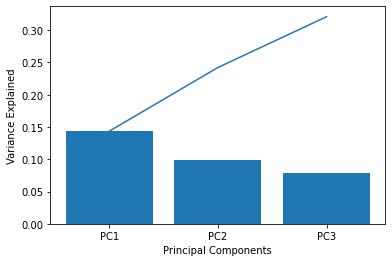

In [45]:
x = ['PC1', 'PC2', 'PC3']
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

Using SVD for reduction, Singular Value Decomposition

In [ ]:
# convert DataFrame to RDD
df_svd_vector = df.rdd.map(lambda x: x['features'].toArray())
mat = RowMatrix(df_svd_vector)

# compute the top 5 singular values & corresponding singular vectors
svd = mat.computeSVD(5, computeU=True)
U = svd.U # row matrix
s = svd.s # singular values are stored in a local dense vector
V = svd.V # local dense matrix

print('U: {} \n S: {} \n V: {}'.format(U, s, V))

In [49]:
df.select('features').show(5, truncate=False)

+----------------------------------------------------------------------+
|features                                                              |
+----------------------------------------------------------------------+
|(16,[0,1,2,3,4,5,7,9,13],[58.0,2143.0,5.0,261.0,1.0,-1.0,1.0,1.0,1.0])|
|(16,[0,1,2,3,4,5,7,8,13],[44.0,29.0,5.0,151.0,1.0,-1.0,2.0,1.0,1.0])  |
|(16,[0,1,2,3,4,5,7,12,13],[33.0,2.0,5.0,76.0,1.0,-1.0,7.0,1.0,1.0])   |
|(16,[0,1,2,3,4,5,9,13],[47.0,1506.0,5.0,92.0,1.0,-1.0,3.0,1.0])       |
|[33.0,1.0,5.0,198.0,1.0,-1.0,0.0,11.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0]|
+----------------------------------------------------------------------+
only showing top 5 rows



In [52]:
features_df

,vals,idx,name
0,"[blue-collar, management, technician, admin., ...",7,job
1,"[married, single, divorced, __unknown]",8,marital
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education
3,"[no, yes, __unknown]",10,default
4,"[yes, no, __unknown]",11,housing
5,"[no, yes, __unknown]",12,loan
6,"[cellular, unknown, telephone, __unknown]",13,contact
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month
8,"[unknown, failure, other, success, __unknown]",15,poutcome


In [53]:
# using ChiSQ selector, I checked online for more examples to better assimilate

selector = ChiSqSelector(numTopFeatures=6, featuresCol='features', outputCol='selectedFeatures',
                labelCol='y')
chi_selector = selector.fit(df)
result = chi_selector.transform(df)

print('selected Indices: ', chi_selector.selectedFeatures)
features_df['chisq_importance'] = features_df['idx'].apply(lambda x: 1 if x
                in chi_selector.selectedFeatures else 0)
print(features_df)

selected Indices:  [0, 1, 2, 3, 4, 5]
                                                vals  idx       name  \
0  [blue-collar, management, technician, admin., ...    7        job   
1             [married, single, divorced, __unknown]    8    marital   
2  [secondary, tertiary, primary, unknown, __unkn...    9  education   
3                               [no, yes, __unknown]   10    default   
4                               [yes, no, __unknown]   11    housing   
5                               [no, yes, __unknown]   12       loan   
6          [cellular, unknown, telephone, __unknown]   13    contact   
7  [may, jul, aug, jun, nov, apr, feb, jan, oct, ...   14      month   
8      [unknown, failure, other, success, __unknown]   15   poutcome   

   chisq_importance  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0  
6                 0  
7                 0  
8                 0  


Model-Based Feature Selection

In [55]:

rf = RandomForestClassifier(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(df)
rf_model.featureImportances 
# this outputs the Feature Importance for each column
# we could then set a SCORE where columns less than would be discarded
# remeber that the columns are named with numbers 0 - 15

SparseVector(16, {0: 0.0149, 1: 0.003, 2: 0.0046, 3: 0.4328, 4: 0.003, 5: 0.0328, 6: 0.0116, 7: 0.008, 8: 0.0054, 9: 0.0008, 10: 0.0, 11: 0.0268, 13: 0.0066, 14: 0.1489, 15: 0.3006})

In [57]:
# format the outputs of DF
for k, v in df.schema['features'].metadata['ml_attr']['attrs'].items():
    features_df = pd.DataFrame(v)

# temporary output rf_output
rf_output = rf_model.featureImportances
features_df['Importance'] = features_df['idx'].apply(lambda x: rf_output[x] if x in
                                    rf_output.indices else 0)

features_df.sort_values('Importance', ascending=False, inplace=True) 
features_df # table showing the Feature_importances

,vals,idx,name,Importance
8,"[unknown, failure, other, success, __unknown]",15,poutcome,0.300575
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month,0.148945
4,"[yes, no, __unknown]",11,housing,0.026832
0,"[blue-collar, management, technician, admin., ...",7,job,0.007997
6,"[cellular, unknown, telephone, __unknown]",13,contact,0.006633
1,"[married, single, divorced, __unknown]",8,marital,0.005445
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education,0.000843
3,"[no, yes, __unknown]",10,default,0.000014
5,"[no, yes, __unknown]",12,loan,0.000000


Text(0, 0.5, 'Variable Importance')

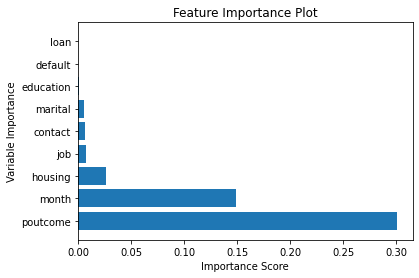

In [58]:

plt.barh(features_df['name'], features_df['Importance'])
plt.title('Feature Importance Plot')
plt.xlabel('Importance Score')
plt.ylabel('Variable Importance')
